In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from xhistogram.xarray import histogram
from matplotlib import colors as cols
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

plt.rcParams.update({'font.size': 16})

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.39:36043 Dashboard: http://10.148.0.39:8787/status,Cluster Workers: 21 Cores: 21 Memory: 335.37 GiB


_________
# 1. Read dataset



In [5]:
# Vorticity/f
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
# Strain/f
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
# w'b'
store_dir_zarr = '/home1/scratch/xyu/Energtics/'
wb_spatial_prime_filter = xr.open_zarr(store_dir_zarr+'wb_spatial_prime_filter.zarr')
wb_spatial_prime_filter = wb_spatial_prime_filter.wb_spatial_prime_filter
wb_spatial_prime_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


# 2. Merge and time series

In [8]:
ds_vs = xr.merge([zeta,strain,wb_spatial_prime_filter])
print(ds_vs)
print('\n data size: %.1f GB' %(ds_vs.nbytes / 1e9))

<xarray.Dataset>
Dimensions:                  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth                    (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
  * lat                      (lat) float64 47.4 47.42 47.43 ... 49.98 49.99
  * lon                      (lon) float64 -18.03 -18.01 ... -14.39 -14.36
  * time                     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T...
Data variables:
    zeta_single              (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>
    strain_single            (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    wb_spatial_prime_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 209.0 GB


Text(0.5, 0, '')

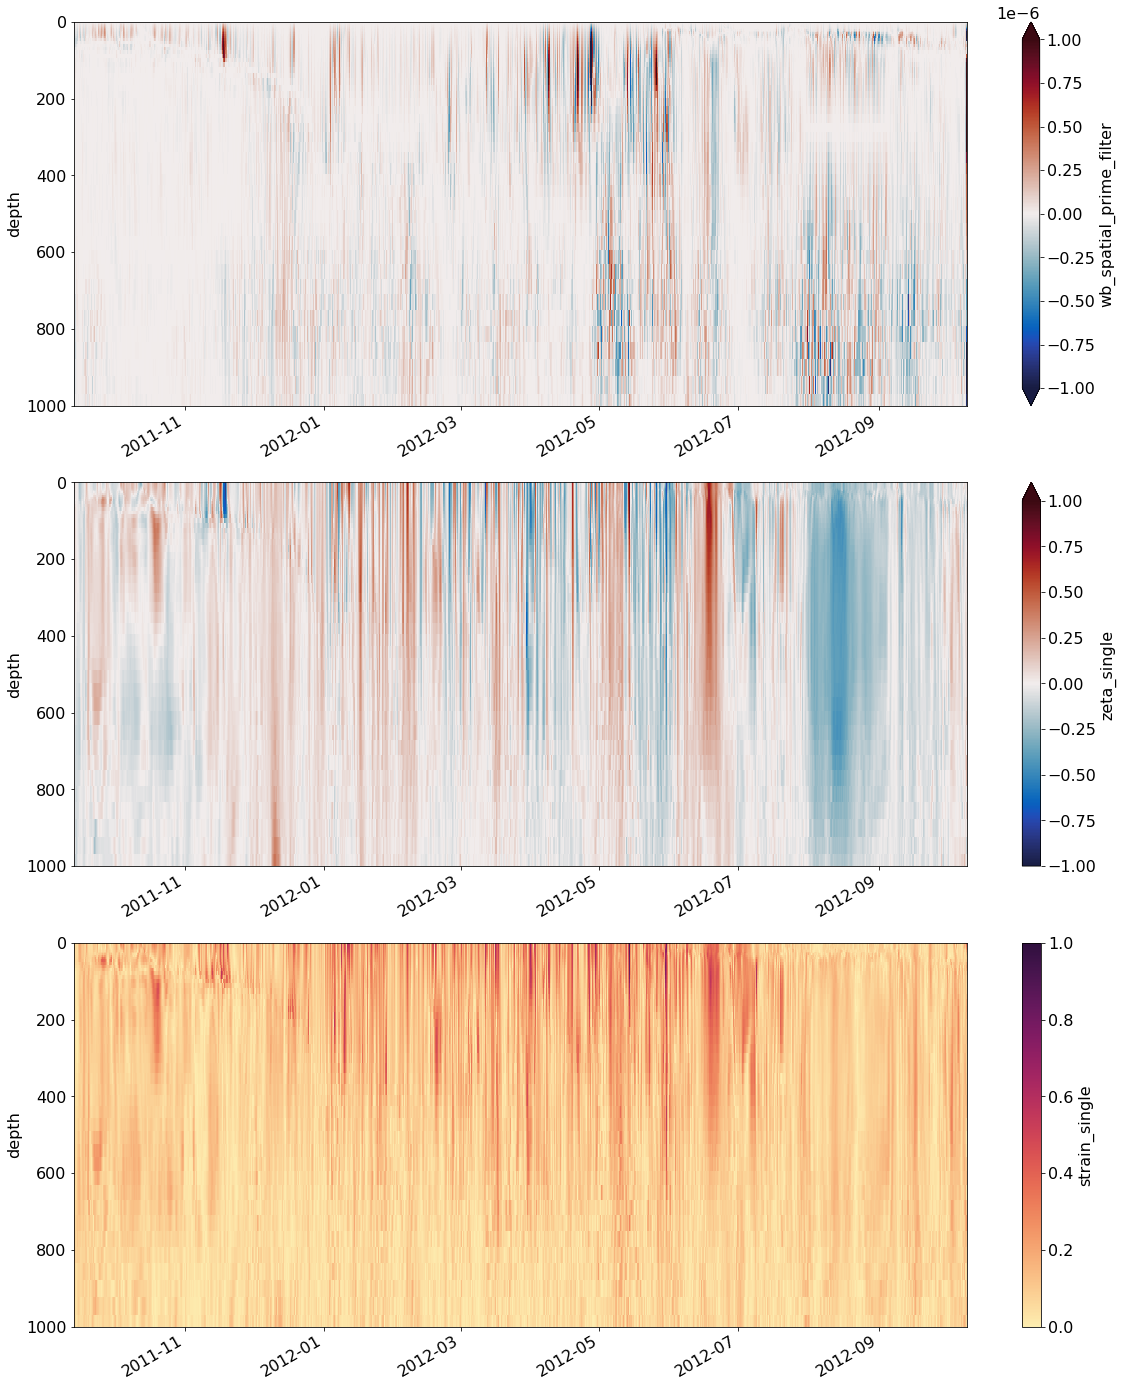

In [17]:
fig = plt.figure(figsize=(20,24))

ax = plt.subplot(311)
ds_vs.wb_spatial_prime_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-6,vmax=1e-6,cmap=cm.balance, yincrease=False)
ax.set_ylim(1000, 0)
ax.set_title('')
plt.xlabel('')

ax = plt.subplot(312)
ds_vs.zeta_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(1000, 0)
ax.set_title('')
plt.xlabel('')

ax = plt.subplot(313)
ds_vs.strain_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1,cmap=cm.matter, yincrease=False)
ax.set_ylim(1000, 0)
ax.set_title('')
plt.xlabel('')

______
# 3. Joint-PDF
# Vertical buoyancy flux （$w^\prime b^\prime$）
# Winter


In [9]:
ndepth = [16, 21, 28, 32, 36, 39] # 52m, 100m, 200m, 299.5m, 410m, 500m
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.wb_spatial_prime_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.735999.datarmor0/ipykernel_34703/3630618820.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/3630618820.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/3630618820.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

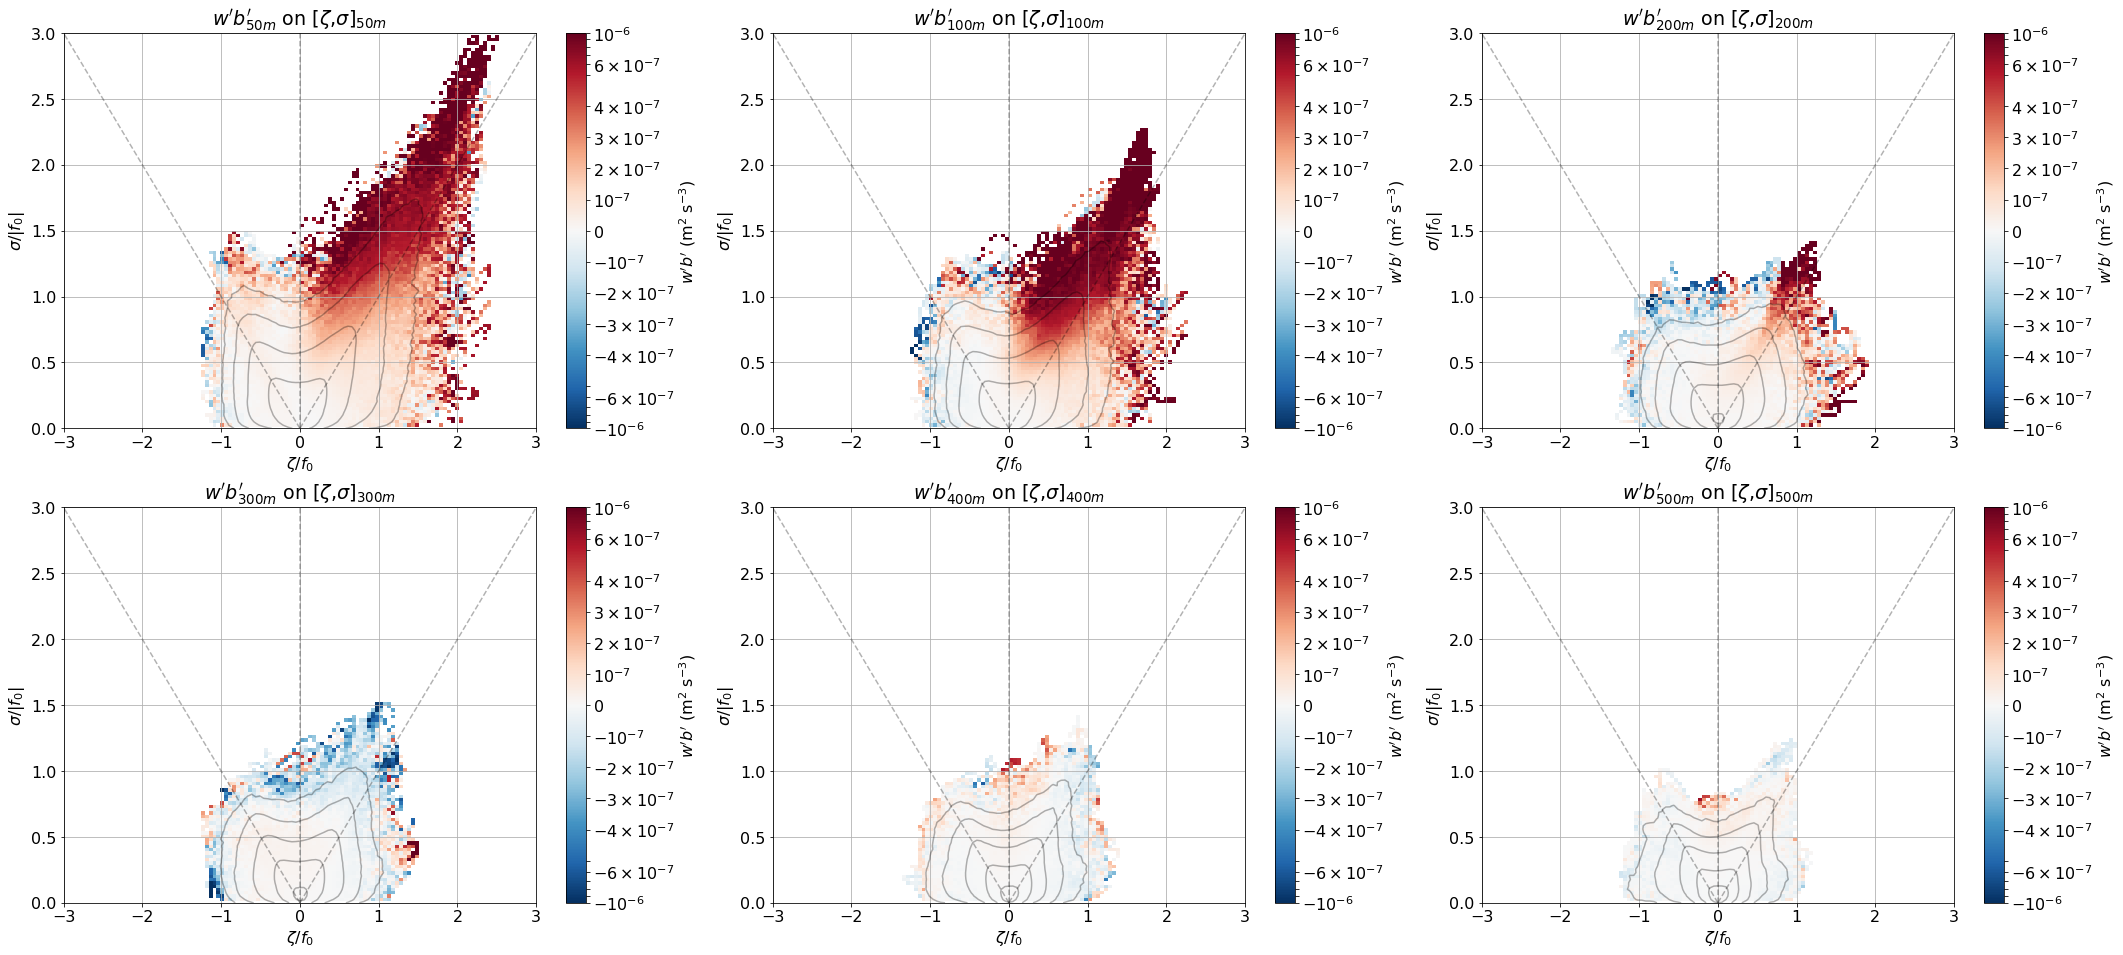

In [10]:
# w'b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,16))

ax = plt.subplot(231)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{50m}$ on [$\zeta$,$\sigma$]$_{50m}$')


ax = plt.subplot(232)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(233)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')

ax = plt.subplot(234)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(235)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=4), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=4).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{400m}$ on [$\zeta$,$\sigma$]$_{400m}$')


ax = plt.subplot(236)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=5), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=5).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_wb_6depths_winter.png')

/dev/shm/pbs.735999.datarmor0/ipykernel_34703/4255197229.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/4255197229.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/4255197229.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

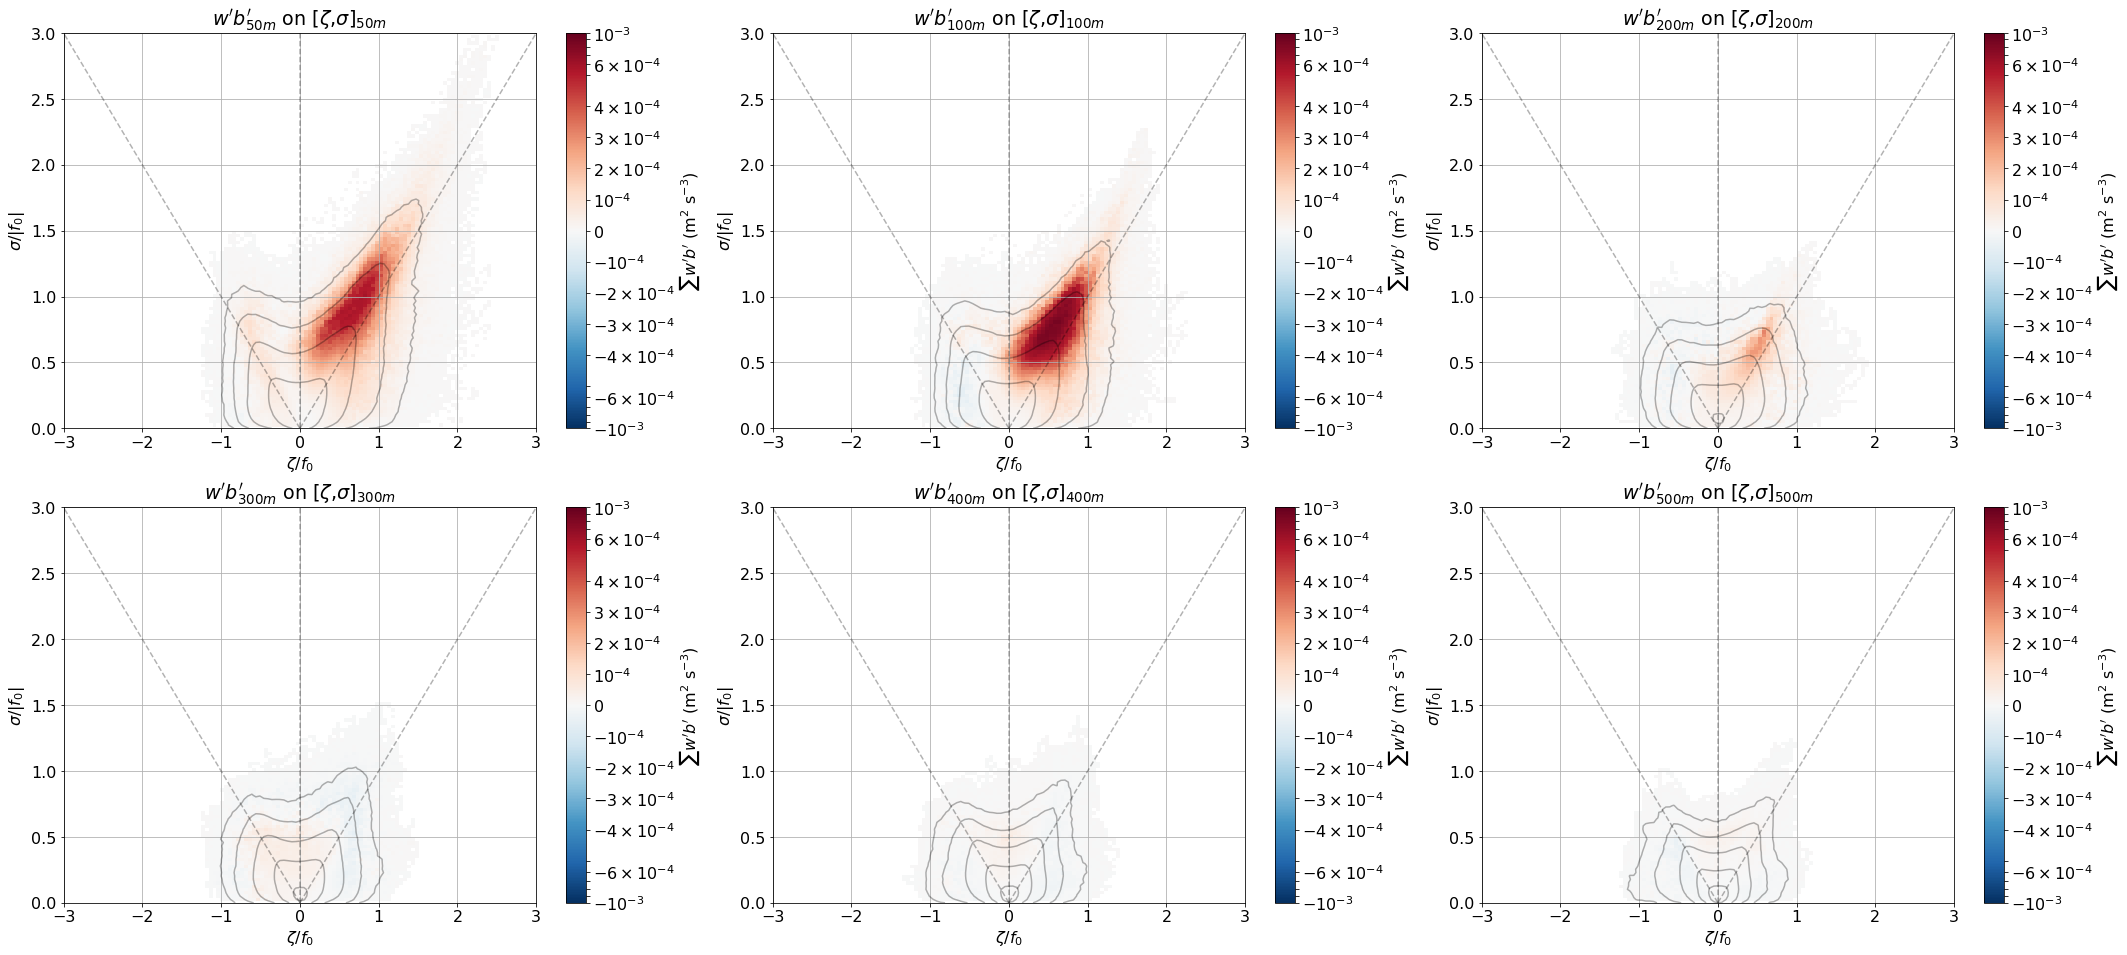

In [11]:
# w‘b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,16))

ax = plt.subplot(231)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{50m}$ on [$\zeta$,$\sigma$]$_{50m}$')


ax = plt.subplot(232)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(233)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(234)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(235)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=4), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=4).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{400m}$ on [$\zeta$,$\sigma$]$_{400m}$')


ax = plt.subplot(236)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=5), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=5).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_wb_6depths_winter.png')

______
# Vertical buoyancy flux （$w^\prime b^\prime$）
# Summer


In [12]:
ndepth = [16, 21, 28, 32, 36, 39] # 52m, 100m, 200m, 299.5m, 410m, 500m
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.wb_spatial_prime_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.735999.datarmor0/ipykernel_34703/1128089579.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/1128089579.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/1128089579.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

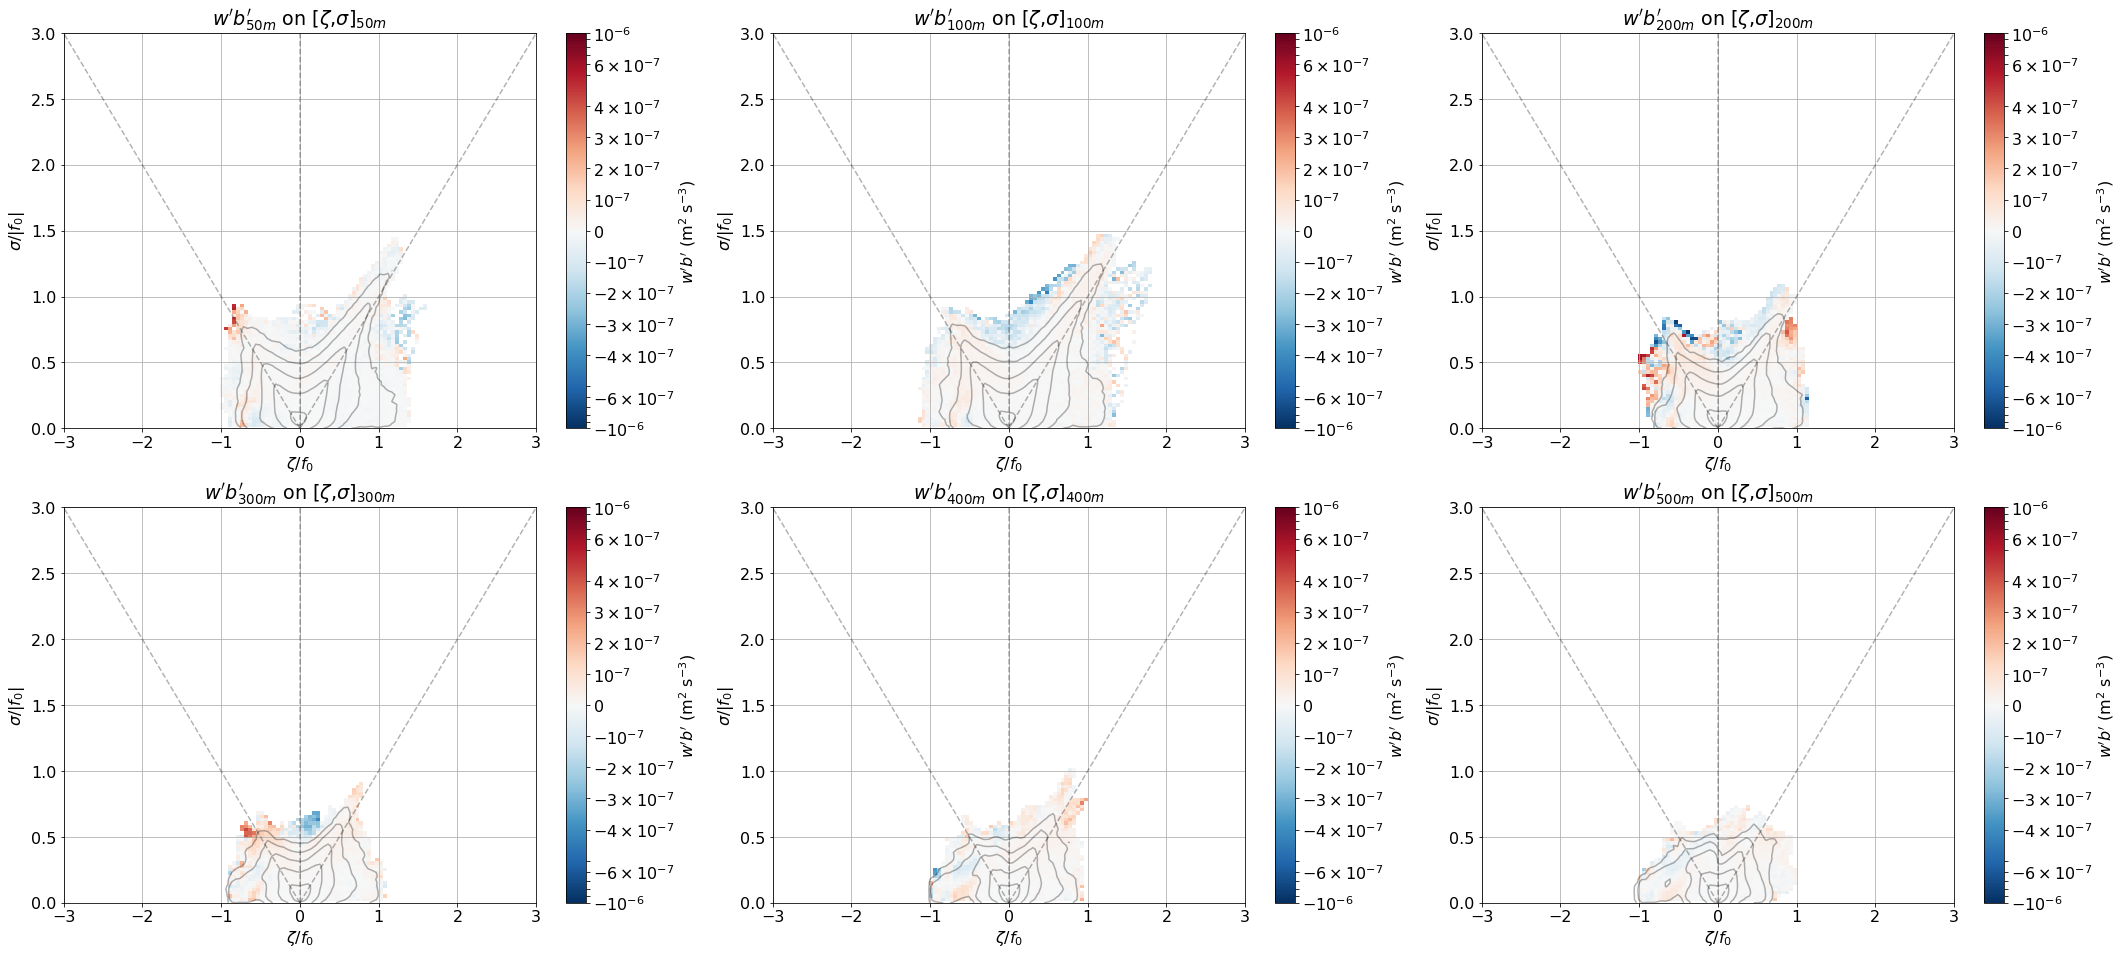

In [13]:
# w'b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,16))

ax = plt.subplot(231)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{50m}$ on [$\zeta$,$\sigma$]$_{50m}$')


ax = plt.subplot(232)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(233)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')

ax = plt.subplot(234)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(235)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=4), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=4).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{400m}$ on [$\zeta$,$\sigma$]$_{400m}$')


ax = plt.subplot(236)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=5), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=5).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_wb_6depths_summer.png')

/dev/shm/pbs.735999.datarmor0/ipykernel_34703/186318776.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/186318776.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.735999.datarmor0/ipykernel_34703/186318776.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eithe

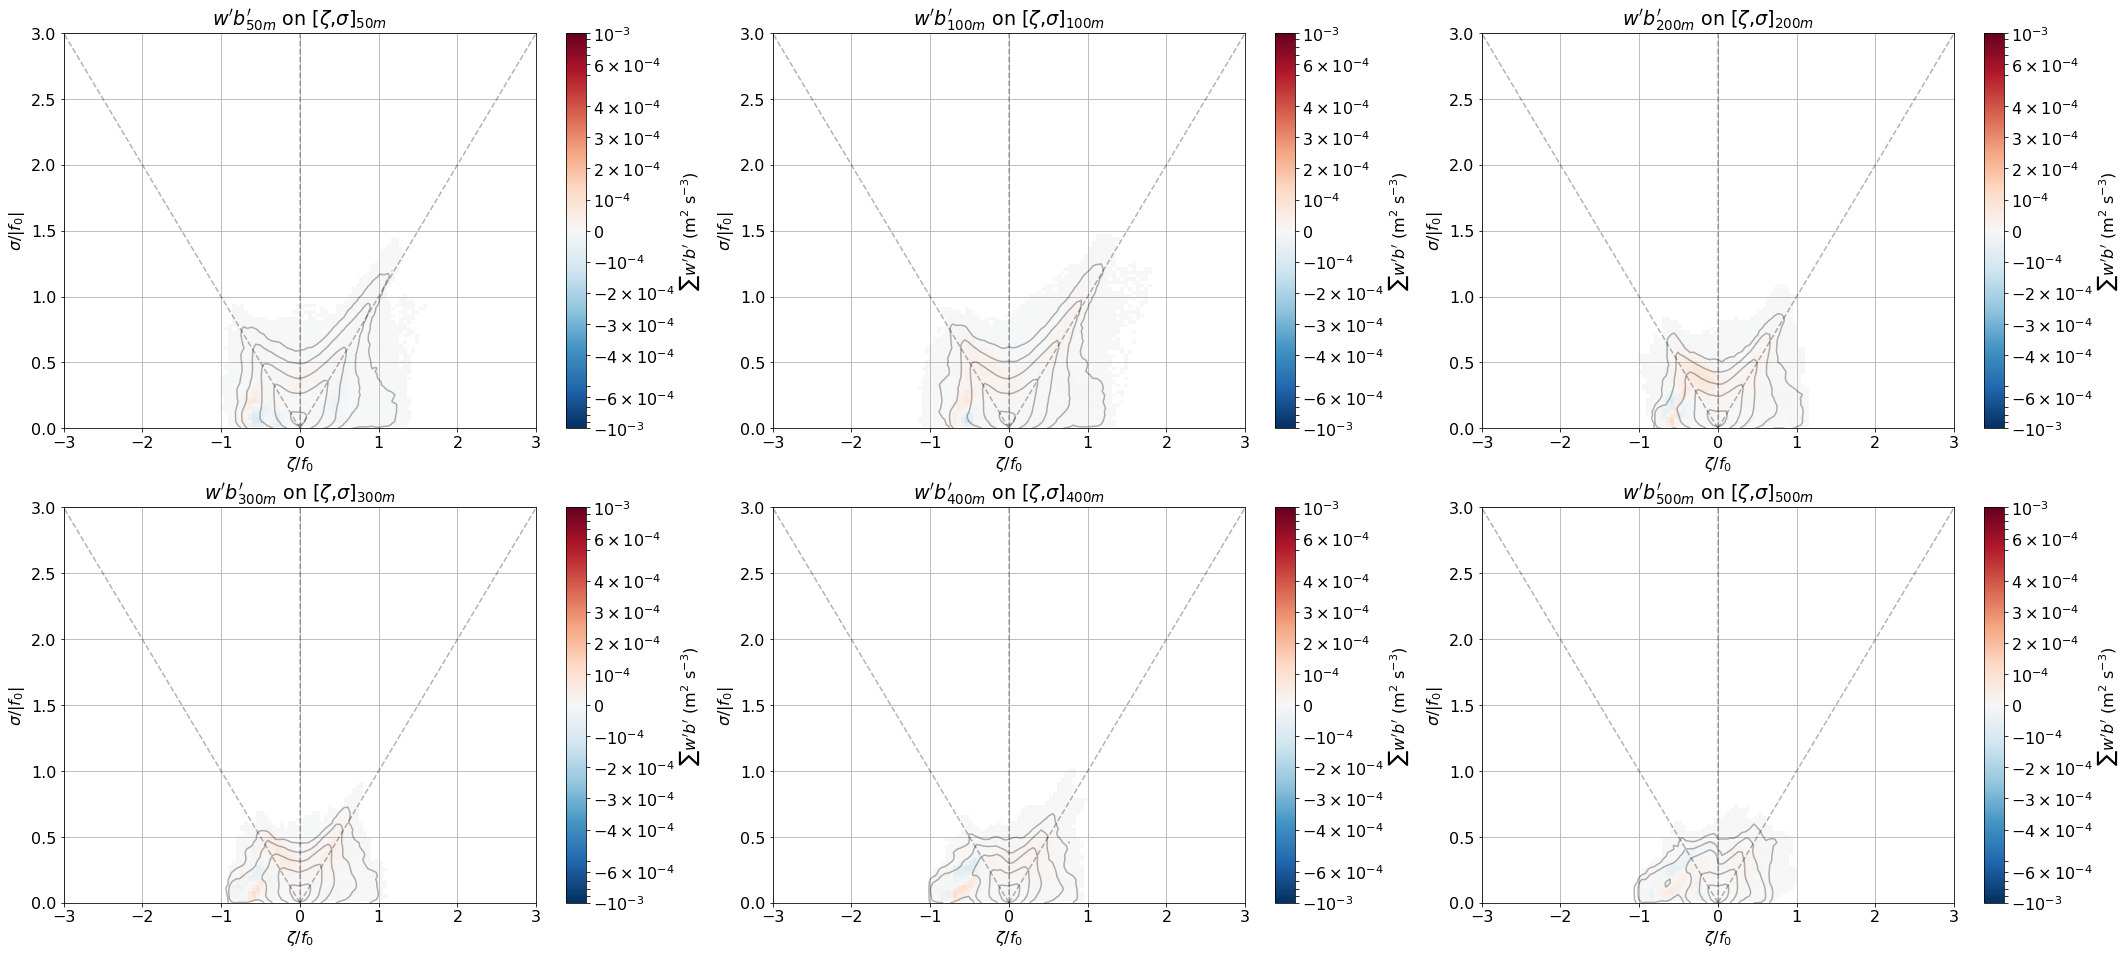

In [14]:
# w‘b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,16))

ax = plt.subplot(231)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{50m}$ on [$\zeta$,$\sigma$]$_{50m}$')


ax = plt.subplot(232)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(233)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(234)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(235)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=4), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=4).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{400m}$ on [$\zeta$,$\sigma$]$_{400m}$')


ax = plt.subplot(236)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=5), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=5).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_wb_6depths_summer.png')

In [16]:
cluster.close()